# Modeling

This is the code for the modeling portion of the project. All of the variables we use in the final model were chosen previously through various methods, and in this notebook we tested the accuracy of a variety of models initially and tuned the parameters for a logistic regression model and a random forest model. The cross-validation score we used to choose the best parameters for the model was our average days improvement metric. This metric is defined as follows: 

    Inspecting the restaurants in descending order of estimated failure probability would have resulted in finding           restaurants that failed their most recent inspections an average of X days earlier than they were actually found.

This makes sense since our objective is really to find restaurants that are going to fail their inspections earlier, not to accurately classify inspections as passes or failures. Ultimately, this resulted in better models in terms of optimizing our average days improvement metric for the test set than using accuracy for the cross-validation score did. We found that the tuned random forest model performed slightly better on the test set than the tuned logistic regression model. 

Our training set consisted of most recent inspections for each restaurant from January 2010 through June 2016. Our test set consisted of most recent inspections for each restaurant from July 2016 through October 2016.

Inspecting the restaurants in descending order of estimated failure probability using the random forest model would have resulted in finding restaurants inspected from July 2016 through October 2016 (this was our test set) that failed their inspections an average of 7.4 days earlier than they were actually found. 75% of the failures occurring in this timeframe would have been found in July and August using the random forest model while 68.3% of the failures were actually found.

In [1]:
# import modules
import numpy as np
import pandas as pd
import scipy as sp
import math
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import tree
from sklearn import ensemble
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.svm import SVC
import csv
import StringIO
import string

In [2]:
# load data and set indices to what they were when written to file
canvass_train = pd.read_csv('canvass_train.csv')
canvass_test = pd.read_csv('canvass_test.csv')
canvass_dum_2 = pd.read_csv('canvass_full_2.csv')
comm_area_prob_fail_df = pd.read_csv('baseline.csv')

canvass_train = canvass_train.set_index(canvass_train.columns[0])
canvass_test = canvass_test.set_index(canvass_test.columns[0])
canvass_dum_2 = canvass_dum_2.set_index(canvass_dum_2.columns[0])

In [3]:
# break train and test into x and y and delete inspection dates and results
canvass_train_y = canvass_train['Results_Fail']
canvass_test_y = canvass_test['Results_Fail']

canvass_train_x = canvass_train.drop(['Results_Fail', 'Inspection Date'], axis = 1)
canvass_test_x = canvass_test.drop(['Results_Fail', 'Inspection Date'], axis = 1)

In [4]:
# length of testing and training sets
print 'Train length: ' + str(len(canvass_train))
print 'Test length: ' + str(len(canvass_test))
print

# accuracy if classify all as pass
print 'Train accuracy if classify all observations as pass: ' + str(1 - np.sum(canvass_train_y)/float(len(canvass_train_y)))
print 'Test accuracy if classify all observations as pass: ' + str(1 - np.sum(canvass_test_y)/float(len(canvass_test_y)))

Train length: 14545
Test length: 1716

Train accuracy if classify all observations as pass: 0.740873152286
Test accuracy if classify all observations as pass: 0.738927738928


In [21]:
# to be used in avg days improvement functions
inspection_date = canvass_dum_2['Inspection Date']

In [22]:
# calculates average number of days improvement from actual inspections using rankings of restaurants from model
# to be used as cross-validation scoring function when tuning parameters
def avg_days_improvement(model, X, y):
    
    global inspection_date # get the inspection dates from the data
    inspection_date_2 = inspection_date.drop(X.index)
    inspection_date_3 = inspection_date.drop(inspection_date_2.index) # get the inspection dates for the obserations in X
    inspection_date_sort = inspection_date_3.sort_values().values # sort the inspection dates for the observations in X
    
    proba_y = model.predict_proba(X) # use model to estimate the probabilities that a restaurant passes or fails
    
    # create a dataframe of results and corresponding inspection dates
    date_result = pd.concat([inspection_date_3, y], axis = 1)
    date_result_sort = date_result.sort_values(by = [date_result.columns[0]])
    
    # create a dataframe of observations, results, and estimated probabilities
    #sort dataframe by descending estimated probability of failure
    # add the sorted inspection dates to the dataframe to see what data we would have inspected a restaurant using model
    X_y = pd.concat([X, y], axis = 1)
    X_y['Prob Fail'] = pd.Series(proba_y[:, 1], index = X_y.index)
    date_proba_result_sort = X_y.loc[:, ('Prob Fail', 'Results_Fail')].sort_values(['Prob Fail'], ascending = False)
    date_proba_result_sort['Inspection Date 2'] = pd.Series(inspection_date_sort, index = date_proba_result_sort.index)
    
    # concatenate the 2 dataframes creates above to get the inspection date deltas for failed inspections
    date_result_pred = pd.concat([date_result_sort, date_proba_result_sort], axis = 1)
    date_result_pred_2 = date_result_pred.iloc[:, (0, 1, 2, 4)]
    
    # subset the above dataframe to look at failures only
    fail_df = date_result_pred_2[date_result_pred_2['Results_Fail'] == 1]
    fail_df['Original - New'] = pd.Series(pd.to_datetime(fail_df['Inspection Date']) - pd.to_datetime(fail_df['Inspection Date 2']))
    
    # calculate average of inspection date deltas for failed inspections
    mean_improvement = np.mean(fail_df['Original - New'])
    days_improvement = mean_improvement.days
    day_fraction = mean_improvement.seconds/(24.0 * 60 * 60)
        
    return days_improvement + day_fraction

In [23]:
# same as above cell except returns avg days improvement as well as vector of improvement deltas and dataframe
# of failed inspections
def avg_days_improvement_2(model, X, y):
    
    global inspection_date
    inspection_date_2 = inspection_date.drop(X.index)
    inspection_date_3 = inspection_date.drop(inspection_date_2.index)
    inspection_date_sort = inspection_date_3.sort_values().values
    
    proba_y = model.predict_proba(X)

    date_result = pd.concat([inspection_date_3, y], axis = 1)
    date_result_sort = date_result.sort_values(by = [date_result.columns[0]])
    
    X_y = pd.concat([X, y], axis = 1)
    X_y['Prob Fail'] = pd.Series(proba_y[:, 1], index = X_y.index)
    date_proba_result_sort = X_y.loc[:, ('Prob Fail', 'Results_Fail')].sort_values(['Prob Fail'], ascending = False)
    date_proba_result_sort['Inspection Date 2'] = pd.Series(inspection_date_sort, index = date_proba_result_sort.index)

    date_result_pred = pd.concat([date_result_sort, date_proba_result_sort], axis = 1)
    date_result_pred_2 = date_result_pred.iloc[:, (0, 1, 2, 4)]

    fail_df = date_result_pred_2[date_result_pred_2['Results_Fail'] == 1]
    fail_df['Original - New'] = pd.Series(pd.to_datetime(fail_df['Inspection Date']) - pd.to_datetime(fail_df['Inspection Date 2']))
    
    mean_improvement = np.mean(fail_df['Original - New'])
    days_improvement = mean_improvement.days
    day_fraction = mean_improvement.seconds/(24.0 * 60 * 60)
    
    improvement_vec = np.array(fail_df['Original - New']) * (1.15741 * (10 ** -14))
    improvement_vec_2 = [int(improvement_vec[i]) for i in range(len(improvement_vec))]
        
    return days_improvement + day_fraction, improvement_vec_2, fail_df

In [8]:
#lda initial results
lda = discriminant_analysis.LinearDiscriminantAnalysis()
lda.fit(canvass_train_x, canvass_train_y)
print 'LDA test accuracy score: ' + str(lda.score(canvass_test_x, canvass_test_y))

LDA test accuracy score: 0.738927738928


In [9]:
#qda initial results
qda = discriminant_analysis.QuadraticDiscriminantAnalysis()
qda.fit(canvass_train_x, canvass_train_y)
print 'QDA test accuracy score: ' + str(qda.score(canvass_test_x, canvass_test_y))

QDA test accuracy score: 0.681818181818


In [17]:
# logistic regression initial results
logreg = linear_model.LogisticRegression(penalty = 'l1', C = 10)
logreg.fit(canvass_train_x, canvass_train_y)
print 'Logistic regression test score: ' + str(logreg.score(canvass_test_x, canvass_test_y))

Logistic regression test score: 0.738927738928


In [11]:
# quadratic logistic initial results
quad_features = preprocessing.PolynomialFeatures(degree = 2)
x_train_expanded = quad_features.fit_transform(canvass_train_x)
x_test_expanded = quad_features.fit_transform(canvass_test_x)

log_reg_poly = linear_model.LogisticRegression(C = 1000)
log_reg_poly.fit(x_train_expanded, canvass_train_y)
print 'Quadatic logistic regression test accuracy score: ' + str(log_reg_poly.score(x_test_expanded, canvass_test_y))

Quadatic logistic regression test accuracy score: 0.737762237762


In [12]:
# random forest initial results
rand_forest = RandomForest(n_estimators = 2001, max_features = 10, max_depth = 9)
rand_forest.fit(canvass_train_x, canvass_train_y)
print 'Random forest test score: ' + str(rand_forest.score(canvass_test_x, canvass_test_y))

Random forest test score: 0.738344988345


We tested several classification models initially to try to determine which ones we should tune the parameters for and consider for our final model. Because there are parameters to tune for logistic regression, we thought we might be able to improve upon the initial result seen here. We also want to tune an ensemble method to see how it would perform. Thus, from here we moved forward with logistic regression and random forest as the potential final models.

In [27]:
# random forest parameter tuning
# tried with several different ranges
rand_forest = RandomForest(n_estimators = 301)

parameter_grid = {'max_features' : range(1, 5, 1),
                  'max_depth' : range(9, 19, 3),
                  'class_weight' : [{0 : 1, 1 : i} for i in [1 + 0.1*j for j in range(5)]]}

grid_randfor = sklearn.grid_search.GridSearchCV(rand_forest, parameter_grid, cv = 4, scoring = avg_days_improvement)
grid_randfor.fit(canvass_train_x, canvass_train_y)

C:\Users\chris\Anaconda2\lib\site-packages\ipykernel\__main__.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=301, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [1, 2, 3, 4], 'max_depth': [9, 12, 15, 18], 'class_weight': [{0: 1, 1: 1.0}, {0: 1, 1: 1.1}, {0: 1, 1: 1.2}, {0: 1, 1: 1.3}, {0: 1, 1: 1.4}]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function avg_days_improvement at 0x000000000C31B5F8>,
       verbose=0)

In [28]:
# parameter results from cross validation for random forest
# CV score and accuracy scoring
# using days improvement function as scoring method for CV
proba_randfor_train = grid_randfor.predict_proba(canvass_train_x)
proba_randfor_test = grid_randfor.predict_proba(canvass_test_x)

# in case I want to alter probability threshold for classifying
pred_randfor_train = []
for i in range(len(proba_randfor_train)):
    if proba_randfor_train[i, 1] >= 0.5:
        pred_randfor_train.append(1)
    else:
        pred_randfor_train.append(0)
        
# in case I want to alter probability threshold for classifying
pred_randfor_test = []
for i in range(len(proba_randfor_test)):
    if proba_randfor_test[i, 1] >= 0.5:
        pred_randfor_test.append(1)
    else:
        pred_randfor_test.append(0)

conf_matrix_train = sklearn.metrics.confusion_matrix(canvass_train_y, pred_randfor_train)
tot_true_neg_train = conf_matrix_train[0, 0] + conf_matrix_train[0, 1]
tot_true_pos_train = conf_matrix_train[1, 0] + conf_matrix_train[1, 1]

conf_matrix_test = sklearn.metrics.confusion_matrix(canvass_test_y, pred_randfor_test)
tot_true_neg_test = conf_matrix_test[0, 0] + conf_matrix_test[0, 1]
tot_true_pos_test = conf_matrix_test[1, 0] + conf_matrix_test[1, 1]

print 'Best parameters from cross validation: ' + str(grid_randfor.best_params_)
print 'CV score of best model: ' + str(grid_randfor.best_score_)
print 'Overall train accuracy: ' + str((conf_matrix_train[0, 0] + conf_matrix_train[1, 1])/float((tot_true_neg_train + tot_true_pos_train)))
print 'Train accuracy when restaurant passes: ' + str(conf_matrix_train[0, 0]/float(tot_true_neg_train))
print 'Train accuracy when restaurant fails: ' + str(conf_matrix_train[1, 1]/float(tot_true_pos_train))
print 'Overall test accuracy: ' + str((conf_matrix_test[0, 0] + conf_matrix_test[1, 1])/float((tot_true_neg_test + tot_true_pos_test)))
print 'Test accuracy when restaurant passes: ' + str(conf_matrix_test[0, 0]/float(tot_true_neg_test))
print 'Test accuracy when restaurant fails: ' + str(conf_matrix_test[1, 1]/float(tot_true_pos_test))

Best parameters from cross validation: {'max_features': 1, 'max_depth': 9, 'class_weight': {0: 1, 1: 1.0}}
CV score of best model: 182.556676664
Overall train accuracy: 0.754898590581
Train accuracy when restaurant passes: 0.998608017817
Train accuracy when restaurant fails: 0.0581055983019
Overall test accuracy: 0.740675990676
Test accuracy when restaurant passes: 0.998422712934
Test accuracy when restaurant fails: 0.0111607142857


In [35]:
# random forest testing using tuned parameters; want to see variable importances
rand_forest_2 = RandomForest(n_estimators = 2001, max_features = 1, class_weight = {0 : 1, 1 : 1.0}, max_depth = 9)
rand_forest_2.fit(canvass_train_x, canvass_train_y)
print 'Random forest test score: ' + str(rand_forest_2.score(canvass_test_x, canvass_test_y))

Random forest test score: 0.737762237762


In [36]:
# create data frame of feature importances from random forest
var_imp = pd.Series(rand_forest_2.feature_importances_)
predictors = pd.Series(canvass_train_x.columns)

var_imp_df = pd.concat([predictors, var_imp], axis = 1, ignore_index = True)

var_imp_df_sort = var_imp_df.sort_values(by = [1], ascending = False)
var_imp_df_sort.reset_index(drop = True, inplace = True)
var_imp_df_sort

,0,1
0,Latitude,0.078048
1,lat_long_interaction,0.077623
2,Longitude,0.074577
3,canvass fail rate,0.058317
4,inspection-fail interaction,0.051044
5,Preterm Births,0.047900
6,consec-fail interaction,0.047504
7,Firearm-related,0.046525
8,Low Birth Weight,0.045887
9,PERCENT HOUSEHOLDS BELOW POVERTY,0.045612


In [249]:
# logistic parameter tuning
# using days improvement function as scoring method for CV
# tried different ranges
log_reg = linear_model.LogisticRegression(penalty = 'l1')

parameter_grid = {'C' : [10**i for i in range(3, -3, -1)],
                  'class_weight' : [{0 : 1, 1 : i} for i in [1 + 0.1*j for j in range(5)]]}

grid_log_reg = sklearn.grid_search.GridSearchCV(log_reg, parameter_grid, cv = 4, scoring = avg_days_improvement)
grid_log_reg.fit(canvass_train_x, canvass_train_y)

C:\Users\chris\Anaconda2\lib\site-packages\ipykernel\__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [1000, 100, 10, 1, 0.1, 0.01], 'class_weight': [{0: 1, 1: 1.0}, {0: 1, 1: 1.1}, {0: 1, 1: 1.2}, {0: 1, 1: 1.3}, {0: 1, 1: 1.4}]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring=<function avg_days_improvement at 0x000000001D3965F8>,
       verbose=0)

In [251]:
# parameter results from cross validation for logistic
# CV score and accuracy scoring
# using days improvement function as scoring method for CV
proba_log_train = grid_log_reg.predict_proba(canvass_train_x)
proba_log_test = grid_log_reg.predict_proba(canvass_test_x)

# in case I want to alter probability threshold for classifying
pred_log_train = []
for i in range(len(proba_log_train)):
    if proba_log_train[i, 1] >= 0.5:
        pred_log_train.append(1)
    else:
        pred_log_train.append(0)
        
# in case I want to alter probability threshold for classifying
pred_log_test = []
for i in range(len(proba_log_test)):
    if proba_log_test[i, 1] >= 0.5:
        pred_log_test.append(1)
    else:
        pred_log_test.append(0)

conf_matrix_train = sklearn.metrics.confusion_matrix(canvass_train_y, pred_log_train)
tot_true_neg_train = conf_matrix_train[0, 0] + conf_matrix_train[0, 1]
tot_true_pos_train = conf_matrix_train[1, 0] + conf_matrix_train[1, 1]

conf_matrix_test = sklearn.metrics.confusion_matrix(canvass_test_y, pred_log_test)
tot_true_neg_test = conf_matrix_test[0, 0] + conf_matrix_test[0, 1]
tot_true_pos_test = conf_matrix_test[1, 0] + conf_matrix_test[1, 1]

print 'Best parameters from cross validation: ' + str(grid_log_reg.best_params_)
print 'CV score of best model: ' + str(grid_log_reg.best_score_)
print 'Overall train accuracy: ' + str((conf_matrix_train[0, 0] + conf_matrix_train[1, 1])/float((tot_true_neg_train + tot_true_pos_train)))
print 'Train accuracy when restaurant passes: ' + str(conf_matrix_train[0, 0]/float(tot_true_neg_train))
print 'Train accuracy when restaurant fails: ' + str(conf_matrix_train[1, 1]/float(tot_true_pos_train))
print 'Overall test accuracy: ' + str((conf_matrix_test[0, 0] + conf_matrix_test[1, 1])/float((tot_true_neg_test + tot_true_pos_test)))
print 'Test accuracy when restaurant passes: ' + str(conf_matrix_test[0, 0]/float(tot_true_neg_test))
print 'Test accuracy when restaurant fails: ' + str(conf_matrix_test[1, 1]/float(tot_true_pos_test))

Best parameters from cross validation: {'C': 10, 'class_weight': {0: 1, 1: 1.0}}
CV score of best model: 143.748252633
Overall train accuracy: 0.740529391543
Train accuracy when restaurant passes: 0.992668893838
Train accuracy when restaurant fails: 0.019633855134
Overall test accuracy: 0.737762237762
Test accuracy when restaurant passes: 0.996845425868
Test accuracy when restaurant fails: 0.00446428571429


In [20]:
# log reg testing using tuned parameters; want to see variable coefficients
log_reg_2 = linear_model.LogisticRegression(penalty = 'l1', class_weight = {0 : 1, 1 : 1.0}, C = 10)
log_reg_2.fit(canvass_train_x, canvass_train_y)

print 'Logistic regression test score: ' + str(log_reg_2.score(canvass_test_x, canvass_test_y))

Logistic regression test score: 0.73951048951


In [11]:
# create data frame of logistic coefficients
coef_series = pd.Series(log_reg_2.coef_[0])
predictors = pd.Series(canvass_train_x.columns)

coef_df = pd.concat([predictors, coef_series], axis = 1, ignore_index = True)

coef_df_sort = coef_df.sort_values(by = [1], ascending = False)
coef_df_sort.reset_index(drop = True, inplace = True)
coef_df_sort

,0,1
0,canvass fail rate,0.695033
1,complaint fail rate,0.168255
2,num prev complaint inspections,0.138893
3,last inspection fail,0.137320
4,Preterm Births,0.055204
5,inspection-fail interaction,0.030996
6,Risk_Risk 1 (High),0.021629
7,PERCENT HOUSEHOLDS BELOW POVERTY,0.012224
8,Firearm-related,0.004794
9,Tuberculosis,0.002833


In [31]:
# logistic parameter tuning
# using accuracy as function to optimize
# tried different ranges
log_reg_3 = linear_model.LogisticRegression()

parameter_grid = {'C' : [10**i for i in range(2, -3, -1)],
                  'penalty' : ['l1', 'l2'],
                  'class_weight' : [{0 : 1, 1 : i} for i in [1 + 0.1*j for j in range(5)]]}

grid_log_reg_2 = sklearn.grid_search.GridSearchCV(log_reg_3, parameter_grid, cv = 4)
grid_log_reg_2.fit(canvass_train_x, canvass_train_y)

GridSearchCV(cv=4, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [100, 10, 1, 0.1, 0.01], 'class_weight': [{0: 1, 1: 1.0}, {0: 1, 1: 1.1}, {0: 1, 1: 1.2}, {0: 1, 1: 1.3}, {0: 1, 1: 1.4}]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [32]:
# parameter results from cross validation for logistic
# CV score and accuracy scoring
proba_log_train = grid_log_reg_2.predict_proba(canvass_train_x)
proba_log_test = grid_log_reg_2.predict_proba(canvass_test_x)

# in case I want to alter probability threshold for classifying
pred_log_train = []
for i in range(len(proba_log_train)):
    if proba_log_train[i, 1] >= 0.5:
        pred_log_train.append(1)
    else:
        pred_log_train.append(0)
        
# in case I want to alter probability threshold for classifying
pred_log_test = []
for i in range(len(proba_log_test)):
    if proba_log_test[i, 1] >= 0.5:
        pred_log_test.append(1)
    else:
        pred_log_test.append(0)

conf_matrix_train = sklearn.metrics.confusion_matrix(canvass_train_y, pred_log_train)
tot_true_neg_train = conf_matrix_train[0, 0] + conf_matrix_train[0, 1]
tot_true_pos_train = conf_matrix_train[1, 0] + conf_matrix_train[1, 1]

conf_matrix_test = sklearn.metrics.confusion_matrix(canvass_test_y, pred_log_test)
tot_true_neg_test = conf_matrix_test[0, 0] + conf_matrix_test[0, 1]
tot_true_pos_test = conf_matrix_test[1, 0] + conf_matrix_test[1, 1]

print 'Best parameters from cross validation: ' + str(grid_log_reg_2.best_params_)
print 'CV score of best model: ' + str(grid_log_reg_2.best_score_)
print 'Overall train accuracy: ' + str((conf_matrix_train[0, 0] + conf_matrix_train[1, 1])/float((tot_true_neg_train + tot_true_pos_train)))
print 'Train accuracy when restaurant passes: ' + str(conf_matrix_train[0, 0]/float(tot_true_neg_train))
print 'Train accuracy when restaurant fails: ' + str(conf_matrix_train[1, 1]/float(tot_true_pos_train))
print 'Overall test accuracy: ' + str((conf_matrix_test[0, 0] + conf_matrix_test[1, 1])/float((tot_true_neg_test + tot_true_pos_test)))
print 'Test accuracy when restaurant passes: ' + str(conf_matrix_test[0, 0]/float(tot_true_neg_test))
print 'Test accuracy when restaurant fails: ' + str(conf_matrix_test[1, 1]/float(tot_true_pos_test))

Best parameters from cross validation: {'penalty': 'l2', 'C': 0.01, 'class_weight': {0: 1, 1: 1.0}}
CV score of best model: 0.739498109316
Overall train accuracy: 0.739566861464
Train accuracy when restaurant passes: 0.993782479584
Train accuracy when restaurant fails: 0.0127354736004
Overall test accuracy: 0.736013986014
Test accuracy when restaurant passes: 0.991324921136
Test accuracy when restaurant fails: 0.0133928571429


C:\Users\chris\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


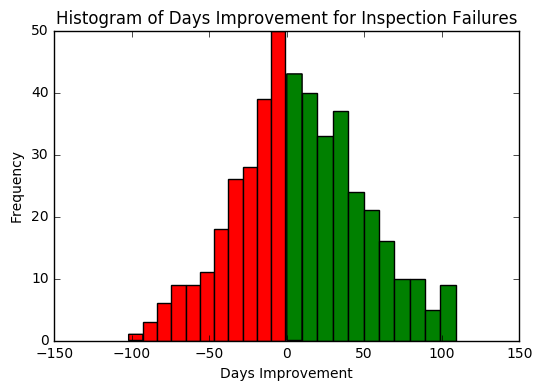

Avg days improvement: 7.35490740741
Median days improvement: 3.5
Standard deviation of days improvement: 41.1566738967
Proportion of failures found earlier: 0.553571428571
Proportion of failures that would have been found in July and August using random forest: 0.756696428571
Proportion of failures actually found in July and August: 0.683035714286


In [33]:
# logistic regression model using days improvement as function to optimize; histogram of days improvement for each 
# restaurant in test set
days_improve = avg_days_improvement_2(log_reg_2, canvass_test_x, canvass_test_y)

positive = [days_improve[1][i] for i in range(len(days_improve[1])) if days_improve[1][i] >= 0]
negative = [days_improve[1][i] for i in range(len(days_improve[1])) if days_improve[1][i] < 0]
plt.hist(positive, bins = 11, color = 'g')
plt.hist(negative, bins = 11, color = 'r')
plt.title('Histogram of Days Improvement for Inspection Failures')
plt.xlabel('Days Improvement')
plt.ylabel('Frequency')
plt.show()
print 'Avg days improvement: ' + str(days_improve[0])
print 'Median days improvement: ' + str(np.median(days_improve[1]))
print 'Standard deviation of days improvement: ' + str(np.std(days_improve[1]))
print 'Proportion of failures found earlier: ' + str(len(positive)/float(len(days_improve[1])))
print 'Proportion of failures that would have been found in July and August using random forest: ' + str(len(days_improve[2][days_improve[2]['Inspection Date 2'] < '2016-09-01'])/float(len(days_improve[2])))
print 'Proportion of failures actually found in July and August: ' + str(len(days_improve[2][days_improve[2]['Inspection Date'] < '2016-09-01'])/float(len(days_improve[2])))

C:\Users\chris\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


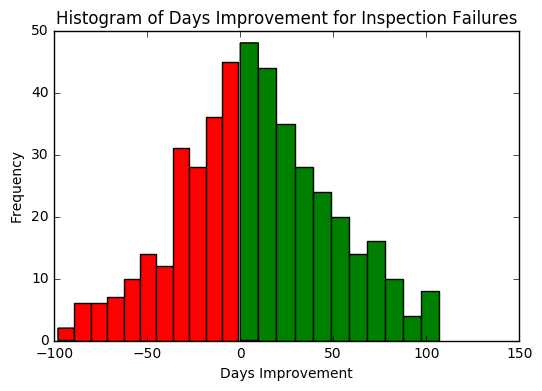

Avg days improvement: 6.82365740741
Median days improvement: 4.0
Standard deviation of days improvement: 40.5293398244
Proportion of failures found earlier: 0.560267857143
Proportion of failures that would have been found in July and August using random forest: 0.758928571429
Proportion of failures actually found in July and August: 0.683035714286


In [34]:
# logistic regression model using accuracy as function to optimize; histogram of days improvement for each 
# restaurant in test set
days_improve_2 = avg_days_improvement_2(grid_log_reg_2, canvass_test_x, canvass_test_y)

positive_2 = [days_improve_2[1][i] for i in range(len(days_improve_2[1])) if days_improve_2[1][i] >= 0]
negative_2 = [days_improve_2[1][i] for i in range(len(days_improve_2[1])) if days_improve_2[1][i] < 0]
plt.hist(positive_2, bins = 11, color = 'g')
plt.hist(negative_2, bins = 11, color = 'r')
plt.title('Histogram of Days Improvement for Inspection Failures')
plt.xlabel('Days Improvement')
plt.ylabel('Frequency')
plt.show()
print 'Avg days improvement: ' + str(days_improve_2[0])
print 'Median days improvement: ' + str(np.median(days_improve_2[1]))
print 'Standard deviation of days improvement: ' + str(np.std(days_improve_2[1]))
print 'Proportion of failures found earlier: ' + str(len(positive_2)/float(len(days_improve_2[1])))
print 'Proportion of failures that would have been found in July and August using random forest: ' + str(len(days_improve_2[2][days_improve_2[2]['Inspection Date 2'] < '2016-09-01'])/float(len(days_improve_2[2])))
print 'Proportion of failures actually found in July and August: ' + str(len(days_improve_2[2][days_improve_2[2]['Inspection Date'] < '2016-09-01'])/float(len(days_improve_2[2])))

C:\Users\chris\Anaconda2\lib\site-packages\ipykernel\__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


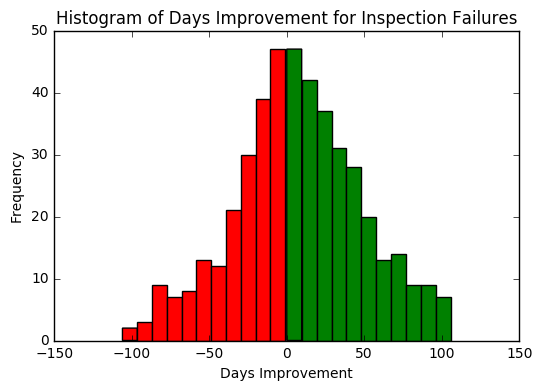

Avg days improvement: 7.36383101852
Median days improvement: 6.0
Standard deviation of days improvement: 41.6559487637
Proportion of failures found earlier or same date: 0.573660714286
Proportion of failures that would have been found in July and August using random forest: 0.75
Proportion of failures actually found in July and August: 0.683035714286


In [37]:
# random forest model using avg days improvement as function to optimize; histogram of days improvement for each 
# restaurant in test set
days_improve_3 = avg_days_improvement_2(rand_forest_2, canvass_test_x, canvass_test_y)

positive_3 = [days_improve_3[1][i] for i in range(len(days_improve_3[1])) if days_improve_3[1][i] >= 0]
negative_3 = [days_improve_3[1][i] for i in range(len(days_improve_3[1])) if days_improve_3[1][i] < 0]
plt.hist(positive_3, bins = 11, color = 'g')
plt.hist(negative_3, bins = 11, color = 'r')
plt.title('Histogram of Days Improvement for Inspection Failures')
plt.xlabel('Days Improvement')
plt.ylabel('Frequency')
plt.show()
print 'Avg days improvement: ' + str(days_improve_3[0])
print 'Median days improvement: ' + str(np.median(days_improve_3[1]))
print 'Standard deviation of days improvement: ' + str(np.std(days_improve_3[1]))
print 'Proportion of failures found earlier or same date: ' + str(len(positive_3)/float(len(days_improve_3[1])))
print 'Proportion of failures that would have been found in July and August using random forest: ' + str(len(days_improve_3[2][days_improve_3[2]['Inspection Date 2'] < '2016-09-01'])/float(len(days_improve_3[2])))
print 'Proportion of failures actually found in July and August: ' + str(len(days_improve_3[2][days_improve_3[2]['Inspection Date'] < '2016-09-01'])/float(len(days_improve_3[2])))

In [31]:
# write days improvement vector of selected random forest model to csv
days_improve_rand_forest = pd.Series(days_improve_3[1])
days_improve_rand_forest.to_csv('days_improve.csv', index = False)